In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np
import yaml
import xarray 
import pathlib
import geopandas as gpd
import time
import sys

mpl.rc('font', size=14)
# some of the following may be repetetive but can also be set relative to the font value above 
#    (eg "xx-small, x-small,small, medium, large, x-large, xx-large, larger, or smaller"; see link above for details)
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=16)
mpl.rc('axes', labelsize=20)
mpl.rc('figure', titlesize=24)
mpl.rc('text', usetex=False)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

In [2]:
in_dir = pathlib.Path("/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/NPP_workshop_120622/")

In [3]:
with open('../etc/SSM_netcdf_config.yaml', 'r') as file:
    ssm_nc = yaml.safe_load(file)
with open('../etc/SSM_config_whidbey.yaml', 'r') as config_file:
    ssm = yaml.safe_load(config_file) 

In [4]:
def running_avg(ts1d, window=24):
    ts1d_24h_avg = []
    i = 0
    while i < (len(ts1d)):
        if i < (len(ts1d)-window):
            ts1d_avg=ts1d[i:i+window].mean()
        else:
            ts1d_avg=np.NaN
        ts1d_24h_avg.append(ts1d_avg)
        i+=1   
    return ts1d_24h_avg

In [5]:
ds={}
NPP_1d_24h={}
for case_name in ["ref","exist"]:
    NPP_1d_24h[case_name]={}
    ds[case_name]={}
    for inlet in ["Bellingham Bay", "Case Inlet", "Sinclair Inlet"]:
        ds[case_name][inlet] = xarray.open_dataset(in_dir/inlet.split(' ')[0]/f"netPP_{inlet.split(' ')[0]}_{case_name}_TS.nc", format='netcdf4')
        NPP_1d_24h[case_name][inlet]=running_avg(ds[case_name][inlet].netPP_median, window=24) 

In [6]:
NPP_1d_24h["difference"]={}
for inlet in ["Bellingham Bay", "Case Inlet", "Sinclair Inlet"]:
    NPP_1d_24h["difference"][inlet]=running_avg(ds["exist"][inlet].netPP_median-ds["ref"][inlet].netPP_median, window=24) 

In [7]:
# create date vector
dti = pd.date_range("2014-01-01", periods=24*366, freq="H")
dti.shape

(8784,)

/tmp/ipykernel_53108/4121310347.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx].set_xticklabels([''])


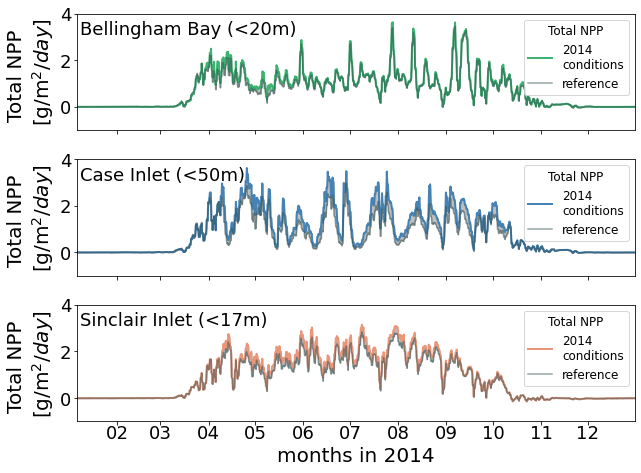

In [8]:
fig, axs = plt.subplots(3,1, figsize = (10,5*3/2),
    gridspec_kw={
       'width_ratios': [1],
       'height_ratios': [1,1,1], 
        'wspace': 0.25,
        'hspace': 0.25})
for idx,inlet in enumerate(["Bellingham Bay", "Sinclair Inlet", "Case Inlet"]):
    axs[idx].plot(dti,NPP_1d_24h["exist"][inlet], color=ssm_nc['inlet_colors'][inlet], lw=2,label='2014\nconditions')
    axs[idx].plot(dti,NPP_1d_24h["ref"][inlet], color='darkslategrey', label='reference',alpha=0.5)
    axs[idx].fill_between(
            dti, 
            NPP_1d_24h["exist"][inlet],
            NPP_1d_24h["ref"][inlet],
            color='grey', 
            alpha=0.5, 
        )
    axs[idx].legend(loc=1, title=f'Total NPP')
    axs[idx].text(pd.Timestamp("2014-01-08"),3.1,f"{ssm_nc['inlet_label'][inlet]}", fontsize=18)
    axs[idx].set_ylabel('Total NPP \n[g/m$^2/day$]')
    axs[idx].set_ylim(-1,4)
    # set x-ticks with x-ticklabels to the first day of the month
    axs[idx].set_xlim(np.datetime64('2014-01-06'), np.datetime64('2014-12-31'))
    axs[idx].xaxis.set_major_locator(mpl.dates.MonthLocator())
    axs[idx].xaxis.set_major_formatter(mpl.dates.DateFormatter('%m'))
    if idx==2:
        axs[idx].set_xlabel('months in 2014')
    else:
         axs[idx].set_xticklabels([''])

plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'NPP_workshop_120622'/'3panel_NPP_BellinghamSinclairCase.png',
            bbox_inches='tight',format='png', dpi = 750)
plt.show()    

/tmp/ipykernel_53108/2360438111.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx].set_xticklabels([''])


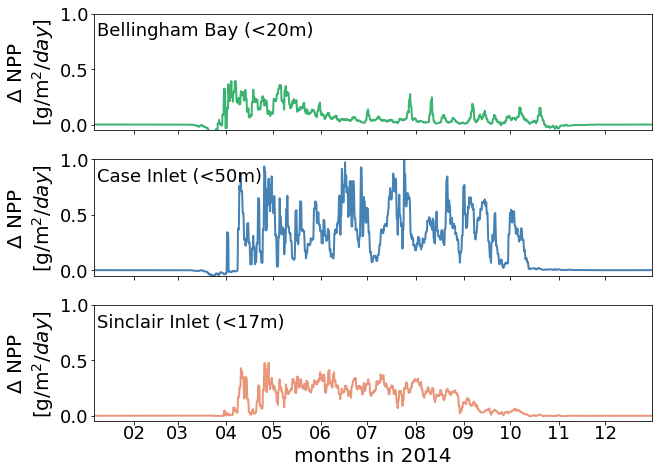

In [9]:
fig, axs = plt.subplots(3,1, figsize = (10,5*3/2),
    gridspec_kw={
       'width_ratios': [1],
       'height_ratios': [1,1,1], 
        'wspace': 0.25,
        'hspace': 0.25})
for idx,inlet in enumerate(["Bellingham Bay", "Sinclair Inlet", "Case Inlet"]):
    axs[idx].plot(dti,NPP_1d_24h["difference"][inlet], color=ssm_nc['inlet_colors'][inlet], lw=2,label='2014 - reference\nconditions')
    axs[idx].text(pd.Timestamp("2014-01-08"),0.8,f"{ssm_nc['inlet_label'][inlet]}", fontsize=18)
    axs[idx].set_ylabel('$\Delta$ NPP \n[g/m$^2/day$]')
    axs[idx].set_ylim(-.05,1)
    # set x-ticks with x-ticklabels to the first day of the month
    axs[idx].set_xlim(np.datetime64('2014-01-06'), np.datetime64('2014-12-31'))
    axs[idx].xaxis.set_major_locator(mpl.dates.MonthLocator())
    axs[idx].xaxis.set_major_formatter(mpl.dates.DateFormatter('%m'))
    if idx==2:
        axs[idx].set_xlabel('months in 2014')
    else:
         axs[idx].set_xticklabels([''])

plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'NPP_workshop_120622'/'3panel_NPP_BellinghamSinclairCase_difference.png',
            bbox_inches='tight',format='png', dpi = 750)
plt.show()    

In [10]:
ds[case_name][inlet]

<xarray.Dataset>
Dimensions:             (time: 8784)
Coordinates:
  * time                (time) float32 43.2 3.637e+03 ... 3.162e+07 3.162e+07
    quantile            float64 ...
Data variables:
    netPP_median        (time) float64 ...
    netPP_quantile_0    (time) float64 ...
    netPP_quantile_100  (time) float64 ...
    netPP_quantile_10   (time) float64 ...
    netPP_quantile_90   (time) float64 ...

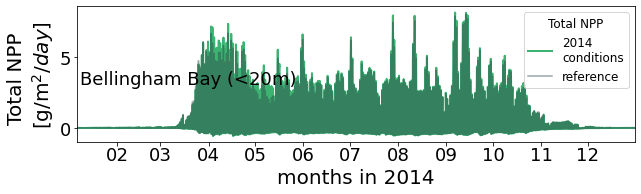

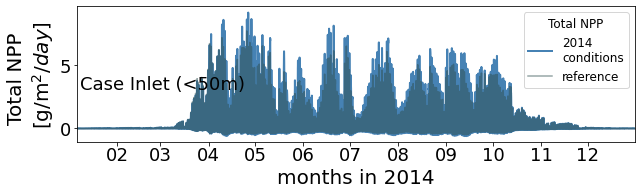

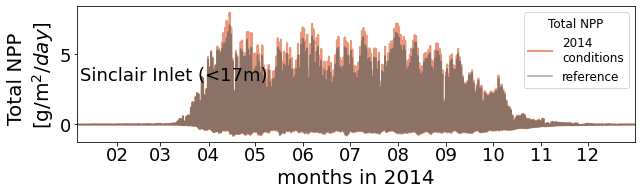

In [11]:

for idx,inlet in enumerate(["Bellingham Bay", "Sinclair Inlet", "Case Inlet"]):
    fig, axs = plt.subplots(1, figsize = (10,5/2),
    gridspec_kw={
       'width_ratios': [1],
       'height_ratios': [1], 
        'wspace': 0.25,
        'hspace': 0.25})
    axs.plot(dti,ds["exist"][inlet].netPP_median, color=ssm_nc['inlet_colors'][inlet], lw=2,label='2014\nconditions')
    axs.plot(dti,ds["ref"][inlet].netPP_median, color='darkslategrey', label='reference',alpha=0.5)
    axs.fill_between(
            dti, 
            NPP_1d_24h["exist"][inlet],
            NPP_1d_24h["ref"][inlet],
            color='grey', 
            alpha=0.5, 
        )
    # #axs[idx].plot(dti,NPP_1d_24h['diff'][f'{node_id}'], color='darkmagenta', label='difference')
    # #plot date of nooksack freshet
    # axs[idx].plot(
    #     [pandas.Timestamp("2014-03-09"), pandas.Timestamp("2014-03-09")],
    #     [-5, 50],
    #     color='grey',
    #     alpha=0.5
    # )
    # if idx==0:
    #     axs[idx].text(pandas.Timestamp("2014-03-09"),52,'Date of Nooksack freshet', color='grey')
    axs.legend(loc=1, title=f'Total NPP')
    axs.text(pd.Timestamp("2014-01-08"),3.1,f"{ssm_nc['inlet_label'][inlet]}", fontsize=18)
    axs.set_ylabel('Total NPP \n[g/m$^2/day$]')
    #axs.set_ylim(-1,4)
    # set x-ticks with x-ticklabels to the first day of the month
    axs.set_xlim(np.datetime64('2014-01-06'), np.datetime64('2014-12-31'))
    axs.xaxis.set_major_locator(mpl.dates.MonthLocator())
    axs.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m'))
    axs.set_xlabel('months in 2014')

plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'NPP_workshop_120622'/f'NPP_{inlet}_median.png',
            bbox_inches='tight',format='png', dpi = 750)
plt.show()    

# Plot one location

In [12]:
input_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/NPP_workshop_120622/')
# exist = input_dir/'Bellingham'/f'2DTS_node_{node}_WQM.nc'
# ref = input_dir/'Bellingham'/f'2DTS_node_{node}_REF.nc'

In [13]:
nodes = {
    "Bellingham Bay":6565, #9m 
    "Case Inlet":15888, #4m
    "Sinclair Inlet":11977 #6m
}

In [14]:
for case_name in ["ref","exist"]:
    NPP_1d_24h[case_name]={}
    ds[case_name]={}
for inlet in ["Bellingham Bay", "Case Inlet", "Sinclair Inlet"]:
    print(inlet)
    ds["exist"][inlet] = xarray.open_dataset(input_dir/"Bellingham"/f'2DTS_node_{nodes[inlet]}_WQM.nc', format='netcdf4')
    NPP_1d_24h["exist"][inlet]=running_avg(ds["exist"][inlet].netPP, window=24)  
    
    ds["ref"][inlet] = xarray.open_dataset(input_dir/"Bellingham"/f'2DTS_node_{nodes[inlet]}_REF.nc', format='netcdf4')
    NPP_1d_24h["ref"][inlet]=running_avg(ds["ref"][inlet].netPP, window=24)  
    
#     ds["exist"][inlet] = xarray.open_dataset(input_dir/inlet.split(" ")[0]/f'2DTS_node_{nodes[inlet]}_WQM.nc', format='netcdf4')
#     NPP_1d_24h["exist"][inlet]=running_avg(ds["exist"][inlet].netPP, window=24)  
    
#     ds["ref"][inlet] = xarray.open_dataset(input_dir/inlet.split(" ")[0]/f'2DTS_node_{nodes[inlet]}_REF.nc', format='netcdf4')
#     NPP_1d_24h["ref"][inlet]=running_avg(ds["ref"][inlet].netPP, window=24)  

Bellingham Bay
Case Inlet
Sinclair Inlet


/tmp/ipykernel_53108/3211366436.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx].set_xticklabels([''])


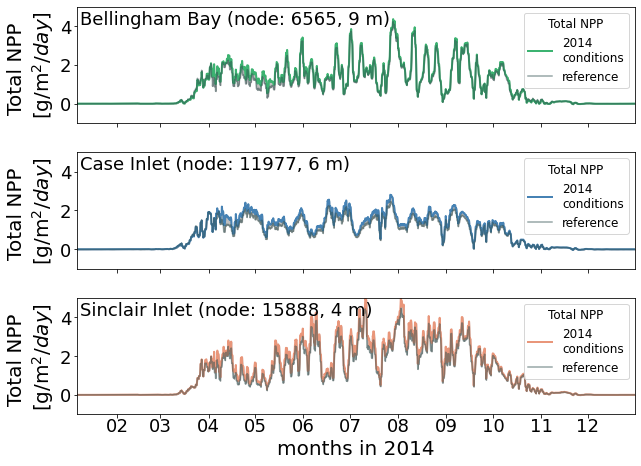

In [15]:
ssm_nc['inlet_label']={
    "Bellingham Bay":f"Bellingham Bay (node: {nodes['Bellingham Bay']}, 9 m)",
    "Case Inlet": f"Sinclair Inlet (node: {nodes['Case Inlet']}, 4 m)",
    "Sinclair Inlet": f"Case Inlet (node: {nodes['Sinclair Inlet']}, 6 m)"
}

fig, axs = plt.subplots(3,1, figsize = (10,5*3/2),
    gridspec_kw={
       'width_ratios': [1],
       'height_ratios': [1,1,1], 
        'wspace': 0.25,
        'hspace': 0.25})
for idx,inlet in enumerate(["Bellingham Bay", "Sinclair Inlet", "Case Inlet"]):
    # axs[idx].plot(dti,ds["exist"][inlet].netPP, color=ssm_nc['inlet_colors'][inlet], lw=2,label='2014\nconditions')
    # axs[idx].plot(dti,ds["ref"][inlet].netPP, color='darkslategrey', label='reference',alpha=0.5)
    axs[idx].plot(dti,NPP_1d_24h["exist"][inlet], color=ssm_nc['inlet_colors'][inlet], lw=2,label='2014\nconditions')
    axs[idx].plot(dti,NPP_1d_24h["ref"][inlet], color='darkslategrey', label='reference',alpha=0.5)
    
    axs[idx].fill_between(
            dti, 
            NPP_1d_24h["exist"][inlet],
            NPP_1d_24h["ref"][inlet],
            color='grey', 
            alpha=0.5, 
        )
    # #axs[idx].plot(dti,NPP_1d_24h['diff'][f'{node_id}'], color='darkmagenta', label='difference')
    # #plot date of nooksack freshet
    # axs[idx].plot(
    #     [pandas.Timestamp("2014-03-09"), pandas.Timestamp("2014-03-09")],
    #     [-5, 50],
    #     color='grey',
    #     alpha=0.5
    # )
    # if idx==0:
    #     axs[idx].text(pandas.Timestamp("2014-03-09"),52,'Date of Nooksack freshet', color='grey')
    axs[idx].legend(loc=1, title=f'Total NPP')
    axs[idx].text(pd.Timestamp("2014-01-08"),4.1,f"{ssm_nc['inlet_label'][inlet]}", fontsize=18)
    axs[idx].set_ylabel('Total NPP \n[g/m$^2/day$]')
    axs[idx].set_ylim(-1,5)
    # set x-ticks with x-ticklabels to the first day of the month
    axs[idx].set_xlim(np.datetime64('2014-01-06'), np.datetime64('2014-12-31'))
    axs[idx].xaxis.set_major_locator(mpl.dates.MonthLocator())
    axs[idx].xaxis.set_major_formatter(mpl.dates.DateFormatter('%m'))
    if idx==2:
        axs[idx].set_xlabel('months in 2014')
    else:
         axs[idx].set_xticklabels([''])
            
file_name = f'3panel_NPP_B{nodes["Bellingham Bay"]}_S{nodes["Sinclair Inlet"]}_C{nodes["Case Inlet"]}.png'

plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'NPP_workshop_120622'/file_name,
            bbox_inches='tight',format='png', dpi = 750)
plt.show()    


In [16]:
NPP_1d_24h["difference"]={}
for inlet in ["Bellingham Bay", "Case Inlet", "Sinclair Inlet"]:
    NPP_1d_24h["difference"][inlet]=running_avg(ds["exist"][inlet].netPP-ds["ref"][inlet].netPP, window=24) 

/tmp/ipykernel_53108/2427749395.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx].set_xticklabels([''])


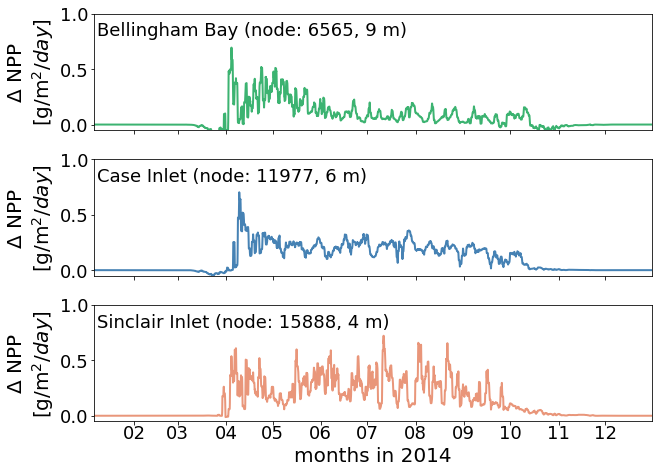

In [17]:
ssm_nc['inlet_label']={
    "Bellingham Bay":f"Bellingham Bay (node: {nodes['Bellingham Bay']}, 9 m)",
    "Case Inlet": f"Sinclair Inlet (node: {nodes['Case Inlet']}, 4 m)",
    "Sinclair Inlet": f"Case Inlet (node: {nodes['Sinclair Inlet']}, 6 m)"
}

fig, axs = plt.subplots(3,1, figsize = (10,5*3/2),
    gridspec_kw={
       'width_ratios': [1],
       'height_ratios': [1,1,1], 
        'wspace': 0.25,
        'hspace': 0.25})
for idx,inlet in enumerate(["Bellingham Bay", "Sinclair Inlet", "Case Inlet"]):
    axs[idx].plot(dti,NPP_1d_24h["difference"][inlet], color=ssm_nc['inlet_colors'][inlet], lw=2,label='2014 - reference\nconditions')
    axs[idx].text(pd.Timestamp("2014-01-08"),0.8,f"{ssm_nc['inlet_label'][inlet]}", fontsize=18)
    axs[idx].set_ylabel('$\Delta$ NPP \n[g/m$^2/day$]')
    axs[idx].set_ylim(-.05,1)
    # set x-ticks with x-ticklabels to the first day of the month
    axs[idx].set_xlim(np.datetime64('2014-01-06'), np.datetime64('2014-12-31'))
    axs[idx].xaxis.set_major_locator(mpl.dates.MonthLocator())
    axs[idx].xaxis.set_major_formatter(mpl.dates.DateFormatter('%m'))
    if idx==2:
        axs[idx].set_xlabel('months in 2014')
    else:
         axs[idx].set_xticklabels([''])

file_name = f'3panel_NPP_Difference_B{nodes["Bellingham Bay"]}_S{nodes["Sinclair Inlet"]}_C{nodes["Case Inlet"]}.png'

plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'NPP_workshop_120622'/file_name,
            bbox_inches='tight',format='png', dpi = 750)
plt.show()   

# check values

In [18]:
# Use shapefile with inlet attributions, provided by Stefano Mazzilli
shp_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-grid/shapefiles/SSMGrid2_tce_ecy_node_info_v2_10102022_inlets')
shp = shp_dir/'SSMGrid2_tce_ecy_node_info_v2_10102022_inlets.shp'
gdf = gpd.read_file(shp)

In [19]:
# Use 2014 baseline results
nc_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-analysis/SSM_model_output/')
nc_file = nc_dir/'NPP_workshop120622_WQM.nc'
ds = xarray.open_dataset(nc_file)

In [20]:
idx=(gdf['tce']==6367)
idx

0        False
1        False
2        False
3        False
4        False
         ...  
16007    False
16008    False
16009    False
16010    False
16011    False
Name: tce, Length: 16012, dtype: bool

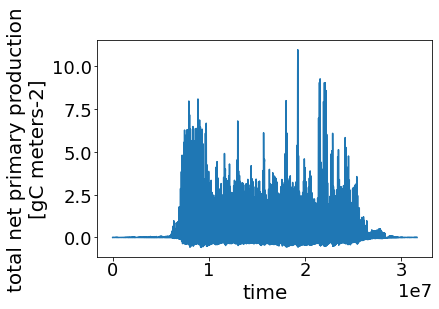

In [21]:
ds.netPP[:,idx].plot()

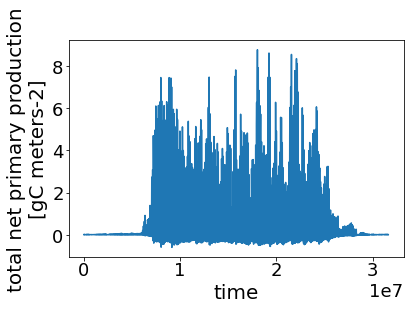

In [22]:
# Use 2014 baseline results
nc_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-analysis/SSM_model_output/')
nc_file = nc_dir/'ssm_output_sediments_WQM.nc'
ds = xarray.open_dataset(nc_file)
idx=(gdf['tce']==6565)
idx
ds.netPP[:,idx].plot()